In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

(150, 150, 3)

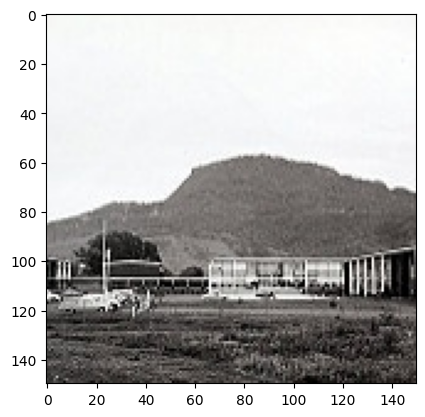

In [2]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/0.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
img.shape

In [3]:
import tensorflow as tf
from keras.utils import image_dataset_from_directory

training_path = '/kaggle/input/intel-image-classification/seg_train/seg_train'
validation_path = '/kaggle/input/intel-image-classification/seg_test/seg_test'

image_size = (150, 150)
batch_size = 32

train_ds = image_dataset_from_directory(
    directory = training_path,
    labels = "inferred",
    label_mode="categorical",
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    verbose = True
)

validation_ds = image_dataset_from_directory(
    directory = validation_path,
    labels = "inferred",
    label_mode="categorical",
    batch_size = batch_size,
    image_size = image_size,
    shuffle = True,
    seed = 42,
    verbose = True
)


2025-10-19 16:09:40.061049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760890180.263244      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760890180.320324      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Found 14034 files belonging to 6 classes.


I0000 00:00:1760890208.282227      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 3000 files belonging to 6 classes.


In [4]:
train_ds.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

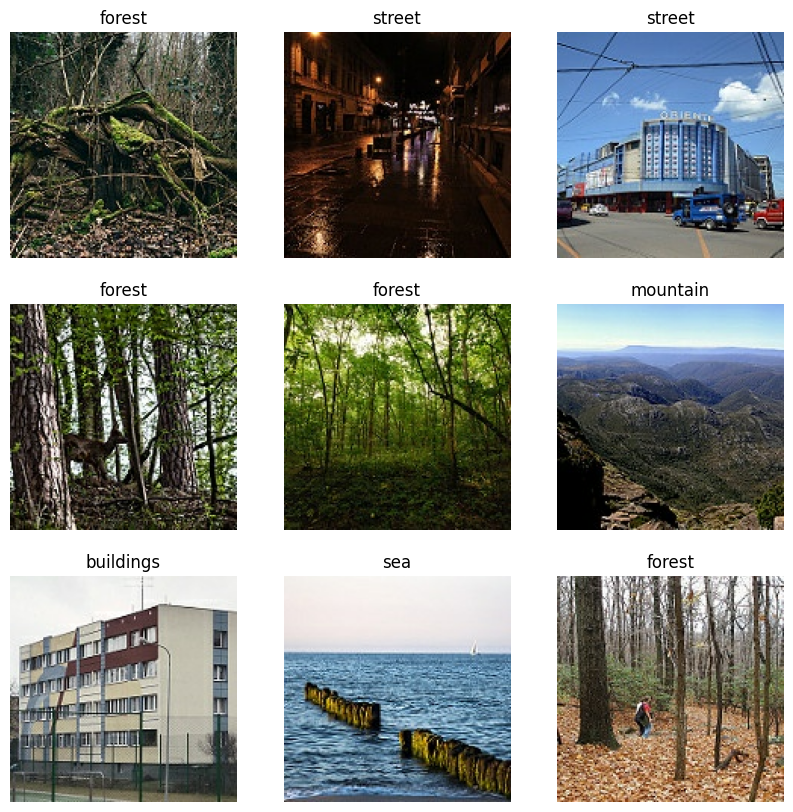

In [5]:
plt.figure(figsize = (10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[tf.argmax(labels[i])])
    plt.axis("off")

# Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images.

It helps expose the model to more aspects of the data and generalize better.

It also makes the model location invariant.

You will implement data augmentation using the following Keras preprocessing layers: tf.keras.layers.RandomFlip, tf.keras.layers.RandomRotation, and tf.keras.layers.RandomZoom. These can be included inside your model like other layers, and run on the GPU.

In [6]:
from keras.models import Sequential
from keras import layers
data_augmentation = Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(150,150,3)), # Remember to provide input
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


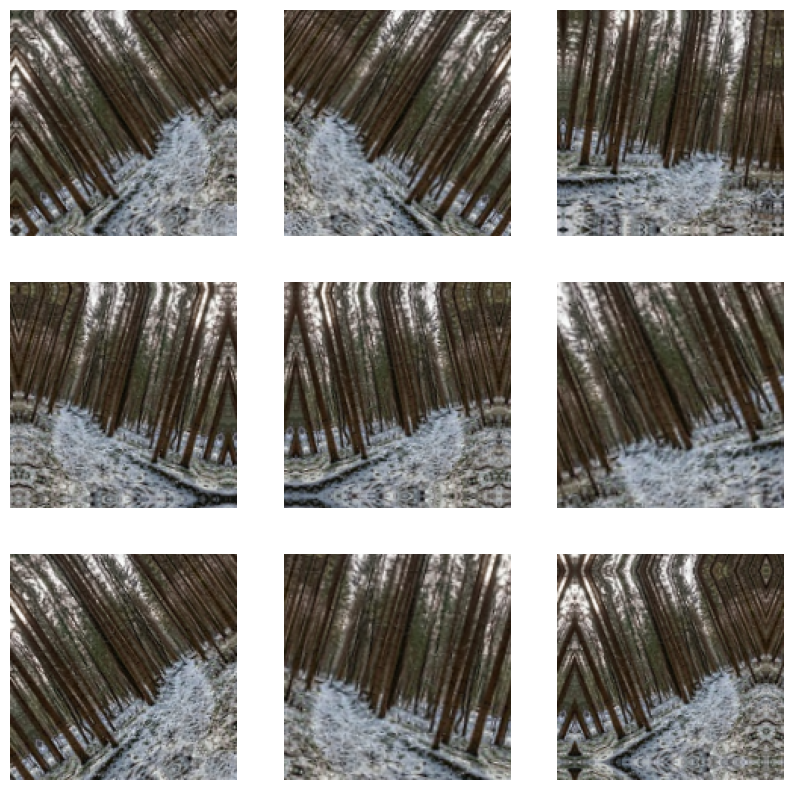

In [7]:
plt.figure(figsize=(10,10))

for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images) # Keep it inside 2nd loop only, since we want to 
                                      # augment image each time with diffent transformation
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

It works very well. Hence we can directly this data_augmentation sub pipeline directly in our model architecture.

# Model Architecture

In [20]:
from keras.layers import Dense, Conv2D, Dropout, MaxPooling2D, Flatten, Rescaling

model = Sequential()

# Preprocessing
model.add( Rescaling(1./255, input_shape = (150, 150, 3)))
model.add( data_augmentation )

# Conv Layers
model.add( Conv2D(filters = 32, kernel_size=(3,3), padding = "valid", strides =1, activation ="relu"))
model.add( MaxPooling2D(pool_size=(2,2), strides=2))

model.add( Conv2D(filters = 64, kernel_size=(3,3), padding = "valid", strides =1, activation ="relu"))
model.add( MaxPooling2D(pool_size=(2,2), strides=2))

model.add( Conv2D(filters = 128, kernel_size=(3,3), padding = "valid", strides =1, activation ="relu"))
model.add( MaxPooling2D(pool_size=(2,2), strides=2))

model.add( Flatten())

# Dense layers
model.add( Dense(units = 64, activation = "relu"))
model.add( Dropout(0.1))

model.add( Dense(units = 128, activation = "relu"))
model.add( Dropout(0.2))

model.add( Dense(units = 64, activation = "relu"))
model.add( Dropout(0.3))

model.add( Dense(units = 6, activation = "softmax"))

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │     2,367,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,477,766 (9.45 MB)

 Trainable params: 2,477,766 (9.45 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile( optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy", "f1_score"])

history = model.fit( train_ds,
                    validation_data = validation_ds,
                    epochs = 15)

Epoch 1/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - accuracy: 0.3975 - f1_score: 0.3767 - loss: 1.4205 - val_accuracy: 0.5620 - val_f1_score: 0.5416 - val_loss: 1.0505
Epoch 2/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6011 - f1_score: 0.5997 - loss: 1.0328 - val_accuracy: 0.7090 - val_f1_score: 0.7117 - val_loss: 0.7870
Epoch 3/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.6739 - f1_score: 0.6732 - loss: 0.8969 - val_accuracy: 0.6813 - val_f1_score: 0.6788 - val_loss: 0.8461
Epoch 4/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7012 - f1_score: 0.7013 - loss: 0.8287 - val_accuracy: 0.7503 - val_f1_score: 0.7525 - val_loss: 0.6880
Epoch 5/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7294 - f1_score: 0.7297 - loss: 0.7553 - val_accuracy: 0.7823 - val_f1_score: 0.7832 - val_loss: 0.6159
Epoch 6/15
439/439 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.7426 - f1_score: 0.7427 - loss: 0.7294 - val_accuracy: 0.7410 - val_f1_score:

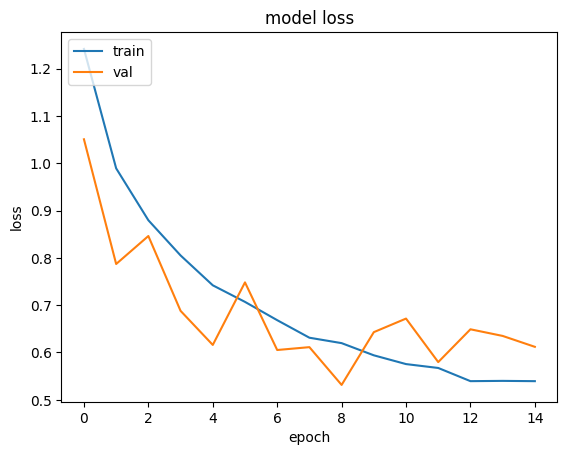

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

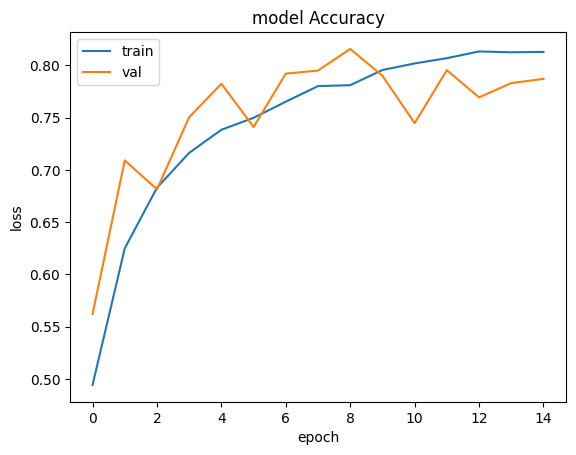

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()